# Quantile Regression

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from qr_util import *

## 1. Build Data

 - Period: 2009/12/31-2018/4/30
 - Stock: **NYSE DIS** (Walt Disney Co.)
 - Factors: Fama-French 3 factors - Mkt, Size(SMB), Value(HML)

In [2]:
tiingo_key = open('/Users/jenchiehcheng/tiingo/tiingo_key.txt').read()
tickers = ['DIS']
start = datetime.datetime(2009, 12, 31)
end = datetime.datetime(2018, 4, 30)

R, F = build_data(tickers, start, end, tiingo_key)

##  2. Split Time Series Data

Retain part of data for cross-validation. Between any two part of data, we drop $n$ days of return to prevent our model from learning the serial correlation in data. Here we simply use $n=5$.

In [3]:
train, cv, test = time_serires_split(R.index, split_ratio=[0.6, 0.2, 0.2], embargo_len=5)

print('Size of All data: %d,'%len(R.index), R.index[0], R.index[-1])
print('Size of Training Set: %d,'%len(train), train[0], train[-1])
print('Size of C-V Set: %d,'%len(cv), cv[0], cv[-1])
print('Size of Test Set: %d,'%len(test), test[0], test[-1])

Size of All data: 2095, 2010-01-04 00:00:00 2018-04-30 00:00:00
Size of Training Set: 1250, 2010-01-04 00:00:00 2014-12-18 00:00:00
Size of C-V Set: 417, 2014-12-29 00:00:00 2016-08-23 00:00:00
Size of Test Set: 418, 2016-08-31 00:00:00 2018-04-30 00:00:00


## 2. Optimization

Given desired quantile $q \in (0, 1)$ and regularization strength $\lambda \geq 0$, find $\beta$ such that the cost function:

$$
\frac{1}{T}\sum_t^T \left[q \left(y_t-\hat{y}_t^{(q)} \right)^+ - (1-q) \left(y_t-\hat{y}_t^{(q)} \right)^-\right] + \lambda \| \beta\|_2^2
$$

is minimized, where

$$\hat{y}_t^{(q)} =  \beta_0 + \sum_{i=1}^K \beta_i F_{i, t} $$

In [4]:
# simple random search for hyperparameter lambda
np.random.seed(7)
L = np.random.uniform(0, 0.0005, size=20)
Q = [0.05, 0.5, 0.95]

b = {}
lamb = {}

for q in Q:
    E = np.inf    
    for l in L:
        
        # estimate coefficient from test set
        temp_b = quantile_reg(R.loc[train, 'DIS'], F.loc[train, :], quantile=q, lamb=l)
        
        # evaluate error on cross-validation set
        temp_error = error(R.loc[cv, 'DIS'], pred(F.loc[cv, :], temp_b), q)
        
        #print(q, l, temp_error)
        if temp_error < E:
            b[q], lamb[q], E = temp_b, l, temp_error

## 4. Performance Measure

In [5]:
r = {}

for q in Q:
    r_pred = pred(F.loc[test, :], b[q])
    r['q=%.2f, lambda=%.5f'%(q, lamb[q])] = r_pred
    print('P(r < r(q=%.2f)) = %.5f'%(q, quantile(R.loc[test, 'DIS'], r_pred)))

P(r < r(q=0.05)) = 0.07656
P(r < r(q=0.50)) = 0.51435
P(r < r(q=0.95)) = 0.95933


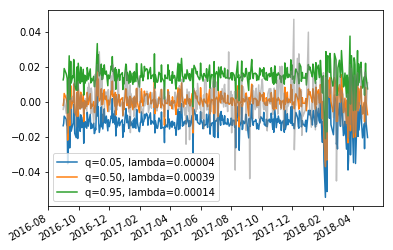

In [6]:
r = pd.DataFrame(r)
r.plot()
R.loc[test, 'DIS'].plot(color='gray', alpha=0.5)

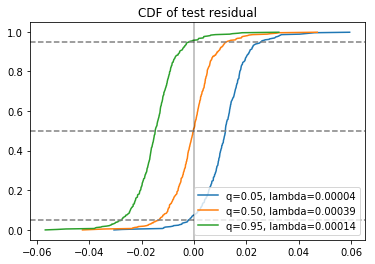

In [7]:
for c in r.columns:
    u = R.loc[test, 'DIS'].values.reshape(-1) - r[c]
    plt.plot(sorted(u), np.arange(0, 1, 1 / u.shape[0]), label=c)

plt.axhline(0.05, color='gray', ls='--')
plt.axhline(0.50, color='gray', ls='--')
plt.axhline(0.95, color='gray', ls='--')
plt.axvline(0, color='k', alpha=0.3)
plt.title('CDF of test residual')
plt.legend()